# gw2 1:1 Bifurcation Diagrams

# Inits

In [1]:
import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is
# user-defined
import nmCoupling as nm
# import nmCoupling_old as nm
import response as rp

import gw2

from lib.util import (get_phase, freq_est, get_tongue_1d, pl_exist_1d, get_period, bif1d, follow_phase_diffs, phase_lock_r3d, follow_locking_3d)

from lib.rhs import _redu_c, _full
from lib.plot_util import add_diagram_1d_scatter, quick_plot_combined

from generate_figures import _redu_3dc_gw as _redu_3dc

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sym

from scipy.optimize import root,bisect
from copy import deepcopy
import os

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

nmc = nm.nmCoupling
rsp = rp.Response

## Dicts

In [2]:
kw_sim = {'rtol':1e-8,'atol':1e-8,'method':'LSODA'}

In [3]:
pd1 = {'v1':.84,'v2':.42,'v4':.35,'v6':.35,'v8':1,
           'k1':1,'k2':1,'k3':.7,'k4':1,'k5':.7,
           'k6':1,'k7':.35,'k8':1,'K':0.5,'kc':1,
           'n':6,'L':0,'del':0,'om':1,'om_fix':1}

In [4]:
kws1 = {'var_names':['x','y','z','v'],
        'pardict':pd1,
        'rhs':gw2.rhs,
        'coupling':gw2.coupling,
        'init':np.array([.3882,.523,1.357,.4347,24.2]),
        'TN':2000,
        'trunc_order':2,
        'z_forward':False,
        'i_forward':False,
        'i_forward':[False,True,False,False,False,False,False],
        'i_bad_dx':[False,True,False,False,False,False,False],
        'max_iter':20,
        'rtol':1e-12,
        'atol':1e-12,
        'rel_tol':1e-9,
        'save_fig':False,
        'lc_prominence':.05,
        'factor':0.5}

## Defs

In [5]:
kw_bif = {'method':'LSODA','dense_output':True,'rtol':1e-9,'atol':1e-9}

In [6]:
eps_list11r = np.linspace(0.001,.1,50)
etup11 = (.001,.1,50)

In [7]:
x_temp = np.linspace(-np.pi,3*np.pi,500)

### rhs redu 4d

In [8]:
def _redu_4dc(t,y,a,eps=.01,del1=0):
    system1 = a.system1;system2 = a.system2
    pdA = a.system1.pardict;pdB = a.system2.pardict

    s,ds = np.linspace(0,2*np.pi*a._m[1],2000,retstep=True)
    thA,psA,thB,psB = y

    om = a._n[1]/a._m[1]
    in1 = thA-om*thB+om*s;in2 = s

    zA = a.th_lam(in1,psA);iA = a.ps_lam(in1,psA)
    zB = a.th_lam(in2,psB);iB = a.ps_lam(in2,psB)

    # coupling terms
    v1 = system1.lc['lam_v0'](in1) + a.g_lam(in1,psA)
    v2 = system2.lc['lam_v1'](in2) + a.g_lam(in2,psB)

    GA = (pdA['K0']*(v1+v2)/2/pdA['kc0']+del1)*pdA['om_fix0']
    GB = (pdB['K1']*(v2+v1)/2/pdB['kc1'])*pdB['om_fix1']

    dthA = eps*np.sum(zA*GA)*ds/(2*np.pi*a._m[1])
    dpsA = a.system1.kappa_val*psA + eps*np.sum(iA*GA)*ds/(2*np.pi*a._m[1])

    dthB = eps*np.sum(zB*GB)*ds/(2*np.pi*a._m[1])
    dpsB = a.system2.kappa_val*psB + eps*np.sum(iB*GB)*ds/(2*np.pi*a._m[1])
    
    return np.array([om*dthA,om*dpsA,dthB,dpsB])

### rhs redu raw

In [9]:
def _redu_4r(t,y,a,eps=.01,del1=0):
    system1 = a.system1;system2 = a.system2
    pdA = a.system1.pardict;pdB = a.system2.pardict

    thA,psA,thB,psB = y

    om = a._n[1]/a._m[1]

    zA = a.th_lam(thA,psA);iA = a.ps_lam(thA,psA)
    zB = a.th_lam(thB,psB);iB = a.ps_lam(thB,psB)

    # coupling terms
    v1 = system1.lc['lam_v0'](thA) + a.g_lam(thA,psA)
    v2 = system2.lc['lam_v1'](thB) + a.g_lam(thB,psB)

    GA = (pdA['K0']*(v1+v2)/2/pdA['kc0']+del1)*pdA['om_fix0']
    GB = (pdB['K1']*(v2+v1)/2/pdB['kc1'])*pdB['om_fix1']

    dthA = 1 + eps*zA*GA
    dpsA = a.system1.kappa_val*psA + eps*iA*GA

    dthB = 1 + eps*zB*GB
    dpsB = a.system2.kappa_val*psB + eps*iB*GB
    
    return np.array([om*dthA,om*dpsA,dthB,dpsB])

## Initialize Response Functions

In [10]:
system1 = rsp(idx=0,model_name='gw0',**kws1)
system2 = rsp(idx=1,model_name='gw1',**kws1)

mkdir ./data/gw0/
* Loading LC data...
self.T 6.283185307179586 omfix 3.859018323065443
* Loading monodromy...
* Floquet Exponent kappa =-0.15846659975382527
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...
mkdir ./data/gw1/
* Loading LC data...
self.T 6.283185307179586 omfix 3.859018323065443
* Loading monodromy...
* Floquet Exponent kappa =-0.15846659975382527
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...


# del=0.0

In [11]:
del11_p0 = 0
a11_p0 = nm.nmCoupling(system1,system2,
                    _n=('om0',1),_m=('om1',1),
                    NH=1000,
                    save_fig=False,
                    del1=del11_p0)

pfactor 4
* Loading p symbolic...
* Loading p symbolic...
* Loading H symbolic...
* Loading H symbolic...
* Loading H gw0, order=0...
* Loading H gw1, order=0...
* Loading H gw0, order=1...
* Loading H gw1, order=1...
* Loading H gw0, order=2...
* Loading H gw1, order=2...


In [12]:
print(np.amin(a11_p0.system1.p['dat'][1]),
      np.amax(a11_p0.system1.p['dat'][1]))
print(np.amin(a11_p0.system1.p['dat'][2]),
      np.amax(a11_p0.system1.p['dat'][2]))

-5.926353114561952 3.0846688137522524
-29.94974105452973 1.015520093830383


## Get Branches Full

In [13]:
kw_p0 = {'a':a11_p0,'del1':del11_p0,'recompute':False,
        'bifdir':'bif1d_gw2/','_full_rhs':_full}

In [14]:
data_p0_list = []

In [15]:
# bot
dat = follow_phase_diffs(init=3,eps_init=0.05,eps_final=0.1,
                         deps=.01,**kw_p0)
data_p0_list.append(dat)

In [16]:
# mid 1f
dat = follow_phase_diffs(init=3,eps_init=0.05,eps_final=0.1,
                         deps=.01,**kw_p0)
data_p0_list.append(dat)

In [17]:
# mid 1b
dat = follow_phase_diffs(init=2.5,eps_init=0.05,eps_final=0.035,
                         deps=-.002,**kw_p0)
data_p0_list.append(dat)

## Get Branches 3D

In [18]:
data_r3d_p0_list = []

In [19]:
# find init for this branch
_,init = phase_lock_r3d([.1,0,0],a11_p0,.05,_redu_3dc)
print(init)

t_diff 3.3230354823240454e-16=[3.32303548e-16 1.02709521e-01 1.02709521e-01]                                                 
[0.     0.1027 0.1027]


In [20]:
# bot 1f
dat = follow_locking_3d(init,a11_p0,(.05,.11,.01),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p0_list.append(dat)

In [21]:
# bot 1b
dat = follow_locking_3d(init,a11_p0,(.05,.001,-.005),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p0_list.append(dat)

## Plot

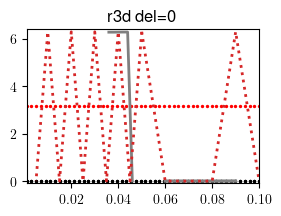

In [22]:
quick_plot_combined(a11_p0,
                    kw_f={'data_list':data_p0_list},
                    kw_r3d={'data_list':data_r3d_p0_list},
                    kw_r={'etup':etup11})

# del=0.01

In [23]:
del11_p01 = 0.01
a11_p01 = nm.nmCoupling(system1,system2,
                    _n=('om0',1),_m=('om1',1),
                    NH=1000,
                    save_fig=False,
                    del1=del11_p01)

pfactor 4
* Loading p symbolic...
* Loading p symbolic...
* Loading H symbolic...
* Loading H symbolic...
* Loading H gw0, order=0...
* Loading H gw1, order=0...
* Loading H gw0, order=1...
* Loading H gw1, order=1...
* Loading H gw0, order=2...
* Loading H gw1, order=2...


## Get Branches Full

In [24]:
kw_p01 = {'a':a11_p01,'del1':del11_p01,'recompute':False,
        'bifdir':'bif1d_gw2/','_full_rhs':_full}

In [25]:
data_p01_list = []

In [26]:
# branch 1f
dat = follow_phase_diffs(init=3,eps_init=0.05,eps_final=0.1,
                         deps=.01,**kw_p01)
data_p01_list.append(dat)

In [27]:
# branch 1b
dat = follow_phase_diffs(init=3,eps_init=0.05,eps_final=0.001,
                         deps=-.002,**kw_p01)
data_p01_list.append(dat)

In [28]:
# # mid 1b
# dat = follow_phase_diffs(init=2.5,eps_init=0.05,eps_final=0.035,
#                          deps=-.002,**kw_p01)
# data_p01_list.append(dat)

## Get Branches 3D

In [29]:
data_r3d_p01_list = []

In [30]:
# find init for this branch
_,init = phase_lock_r3d([1,0,0],a11_p01,.05,_redu_3dc)
print(init)

t_diff 0.50191230254181332, Y=[0.5019123  0.01128253 0.08406823]                                              
[0.5019 0.0113 0.0841]


In [31]:
# bot 1f
dat = follow_locking_3d(init,a11_p01,(.05,.11,.01),
                        rhs=_redu_3dc,recompute=True)
data_r3d_p01_list.append(dat)

eps iter 0 0.05                
t_diff 0.50191230254181210, Y=[0.5019123  0.01128253 0.08406823]                                              
eps iter 1 0.060000000000000005                
t_diff 0.51071376497974058, Y=[0.51071376 0.01430605 0.10044968]                                              
eps iter 2 0.07                
t_diff 0.51955588314091678, Y=[0.51955588 0.01755572 0.11666926]                                              
eps iter 3 0.08000000000000002                
t_diff 0.52849589835539878, Y=[0.5284959  0.02101549 0.13271729]                                              
eps iter 4 0.09000000000000001                
t_diff 0.53759239469398908, Y=[0.53759239 0.02466743 0.14858337]                                              
eps iter 5 0.1                
t_diff 0.54690481588477418, Y=[0.54690482 0.02849179 0.16425653]                                              


In [32]:
# bot 1b
dat = follow_locking_3d(init,a11_p01,(.05,.001,-.005),
                        rhs=_redu_3dc,recompute=True)
data_r3d_p01_list.append(dat)

eps iter 0 0.05                
t_diff 0.50191230254181210, Y=[0.5019123  0.01128253 0.08406823]                                              
eps iter 1 0.045000000000000005                
t_diff 0.49750939023343470, Y=[0.49750939 0.00986011 0.07581957]                                              
eps iter 2 0.04000000000000001                
t_diff 0.49309597027325090, Y=[0.49309597 0.00849946 0.06753364]                                              
eps iter 3 0.03500000000000001                
t_diff 0.48866541582417994, Y=[0.48866542 0.00720209 0.05921137]                                              
eps iter 4 0.030000000000000013                
t_diff 0.48421123787392234, Y=[0.48421124 0.00596942 0.05085362]                                              
eps iter 5 0.025000000000000015                
t_diff 0.47972708984038450, Y=[0.47972709 0.00480279 0.04246116]                                              
eps iter 6 0.020000000000000018                
t_diff 0.4752067

## Plot

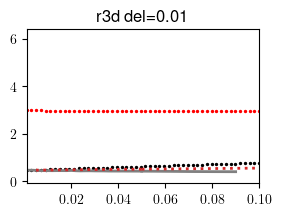

In [33]:
quick_plot_combined(a11_p01,
                    kw_f={'data_list':data_p01_list},
                    kw_r3d={'data_list':data_r3d_p01_list},
                    kw_r={'etup':etup11})

# del=0.03

In [34]:
del11_p03 = 0.03
a11_p03 = nm.nmCoupling(system1,system2,
                        recompute_list=['p_gw0','p_gw1',
                                       'p_data_gw0','p_data_gw1'],
                    _n=('om0',1),_m=('om1',1),
                    NH=1000,
                    save_fig=False,
                    del1=del11_p03)

pfactor 4
* Computing p symbolic...
* Computing p symbolic...
p order=0
p order=0
p order=1
p order=1
p order=2
p order=2
* Loading H symbolic...
* Loading H symbolic...
* Loading H gw0, order=0...
* Loading H gw1, order=0...
* Loading H gw0, order=1...
* Loading H gw1, order=1...
* Loading H gw0, order=2...
* Loading H gw1, order=2...


## Get Branches Full

In [35]:
kw_p03 = {'a':a11_p03,'del1':del11_p03,'recompute':False,
        'bifdir':'bif1d_gw2/','_full_rhs':_full}

In [36]:
data_p03_list = []

In [37]:
# branch 1f
dat = follow_phase_diffs(init=3,eps_init=0.05,eps_final=0.1,
                         deps=.01,**kw_p03)
data_p03_list.append(dat)

In [38]:
# branch 1b
dat = follow_phase_diffs(init=3,eps_init=0.05,eps_final=0.001,
                         deps=-.002,**kw_p03)
data_p03_list.append(dat)

In [39]:
# # mid 1b
# dat = follow_phase_diffs(init=2.5,eps_init=0.05,eps_final=0.035,
#                          deps=-.002,**kw_p03)
# data_p03_list.append(dat)

## Get Branches 3D

In [40]:
data_r3d_p03_list = []

In [41]:
# find init for this branch
_,init = phase_lock_r3d([1,0,0],a11_p03,.05,_redu_3dc)
print(init)

t_diff 1.25733573429608313, Y=[ 1.25733573 -0.21743397 -0.00188245]                                                          
[ 1.2573 -0.2174 -0.0019]


In [42]:
# bot 1f
dat = follow_locking_3d(init,a11_p03,(.05,.11,.01),
                        rhs=_redu_3dc,recompute=True)
data_r3d_p03_list.append(dat)

eps iter 0 0.05                
t_diff 1.25733573429608430, Y=[ 1.25733573 -0.21743397 -0.00188245]                                              
eps iter 1 0.060000000000000005                
t_diff 1.31046154560203723, Y=[ 1.31046155 -0.26598437 -0.00368952]                                              
eps iter 2 0.07                
t_diff 1.37070972025144362, Y=[ 1.37070972 -0.3180521  -0.00715933]                                              
eps iter 3 0.08000000000000002                
t_diff 1.44381996055912270, Y=[ 1.44381996 -0.37620565 -0.01380067]                                              
eps iter 4 0.09000000000000001                
t_diff 1.54458289721276828, Y=[ 1.5445829  -0.44721935 -0.02747139]                                              
eps iter 5 0.1                
t_diff 1.76095212453428961, Y=[ 1.76095212 -0.57142073 -0.07115545]                                              


In [43]:
# bot 1b
dat = follow_locking_3d(init,a11_p03,(.05,.001,-.005),
                        rhs=_redu_3dc,recompute=True)
data_r3d_p03_list.append(dat)

eps iter 0 0.05                
t_diff 1.25733573429608430, Y=[ 1.25733573 -0.21743397 -0.00188245]                                              
eps iter 1 0.045000000000000005                
t_diff 1.23247719480163938, Y=[ 1.23247719 -0.19406694 -0.00134807]                                              
eps iter 2 0.04000000000000001                
t_diff 1.20841896769615059, Y=[ 1.20841897e+00 -1.71173447e-01 -9.72868510e-04]                                              
eps iter 3 0.03500000000000001                
t_diff 1.18497490443509129, Y=[ 1.18497490e+00 -1.48687238e-01 -7.10483078e-04]                                              
eps iter 4 0.030000000000000013                
t_diff 1.16199466071577960, Y=[ 1.16199466e+00 -1.26560023e-01 -5.25440961e-04]                                              
eps iter 5 0.025000000000000015                
t_diff 1.13935518669725041, Y=[ 1.13935519e+00 -1.04757109e-01 -3.91040495e-04]                                             

## Plot

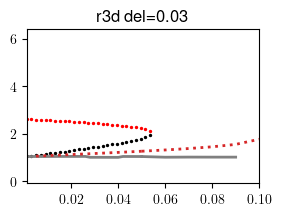

In [44]:
quick_plot_combined(a11_p03,
                    kw_f={'data_list':data_p03_list},
                    kw_r3d={'data_list':data_r3d_p03_list},
                    kw_r={'etup':etup11})

# del=0.04

In [45]:
del11_p04 = 0.04
a11_p04 = nm.nmCoupling(system1,system2,
                        recompute_list=['p_gw0','p_gw1',
                                       'p_data_gw0','p_data_gw1'],
                        _n=('om0',1),_m=('om1',1),
                        NH=1000,
                        save_fig=False,
                        del1=del11_p04)

pfactor 4
* Computing p symbolic...
* Computing p symbolic...
p order=0
p order=0
p order=1
p order=1
p order=2
p order=2
* Loading H symbolic...
* Loading H symbolic...
* Loading H gw0, order=0...
* Loading H gw1, order=0...
* Loading H gw0, order=1...
* Loading H gw1, order=1...
* Loading H gw0, order=2...
* Loading H gw1, order=2...


## Get Branches Full

In [46]:
kw_p04 = {'a':a11_p04,'del1':del11_p04,'recompute':False,
        'bifdir':'bif1d_gw2/','_full_rhs':_full}

In [47]:
data_p04_list = []

In [48]:
# branch 1f
dat = follow_phase_diffs(init=3,eps_init=0.05,eps_final=0.1,
                         deps=.01,**kw_p04)
data_p04_list.append(dat)

In [49]:
# branch 1b
dat = follow_phase_diffs(init=3,eps_init=0.05,eps_final=0.001,
                         deps=-.002,**kw_p04)
data_p04_list.append(dat)

In [50]:
# # mid 1b
# dat = follow_phase_diffs(init=2.5,eps_init=0.05,eps_final=0.035,
#                          deps=-.002,**kw_p04)
# data_p04_list.append(dat)

## Get Branches 3D

In [51]:
data_r3d_p04_list = []

In [52]:
# find init for this branch
_,init = phase_lock_r3d([1,0,0],a11_p04,.05,_redu_3dc)
print(init)

t_diff 1.77910541719762813, Y=[ 1.77910542 -0.37982066 -0.08380547]                                              
[ 1.7791 -0.3798 -0.0838]


In [53]:
# bot 1f
dat = follow_locking_3d(init,a11_p04,(.05,.11,.01),
                        rhs=_redu_3dc,recompute=True)
data_r3d_p04_list.append(dat)

eps iter 0 0.05                
t_diff 1.77910541719762559, Y=[ 1.77910542 -0.37982066 -0.08380547]                                              
eps iter 1 0.060000000000000005                
eps iter 2 0.07                =[ 8.13865275 -0.46787794 -0.09483649]                                                        
t_diff 0.610492672573684612, Y=[38.30960452 -1.75767168 -0.285589  ]                                                          
eps iter 3 0.08000000000000002                
eps iter 4 0.09000000000000001                1.64004149 -0.35165694]                                                
eps iter 5 0.1                Y=[36.88123878  0.06124752  0.10804757]                                                         


In [54]:
# bot 1b
dat = follow_locking_3d(init,a11_p04,(.05,.001,-.005),
                        rhs=_redu_3dc,recompute=True)
data_r3d_p04_list.append(dat)

eps iter 0 0.05                
t_diff 1.77910541719762559, Y=[ 1.77910542 -0.37982066 -0.08380547]                                              
eps iter 1 0.045000000000000005                
t_diff 1.69578295187535298, Y=[ 1.69578295 -0.32933683 -0.06815154]                                              
eps iter 2 0.04000000000000001                
t_diff 1.63084782580553120, Y=[ 1.63084783 -0.28457307 -0.05631153]                                              
eps iter 3 0.03500000000000001                
t_diff 1.57636484622531411, Y=[ 1.57636485 -0.24330324 -0.04661293]                                              
eps iter 4 0.030000000000000013                
t_diff 1.52854566050506072, Y=[ 1.52854566 -0.20444674 -0.03825513]                                              
eps iter 5 0.025000000000000015                
t_diff 1.48520295412447423, Y=[ 1.48520295 -0.16739364 -0.03078619]                                              
eps iter 6 0.020000000000000018               

## Plot

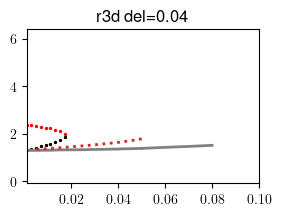

In [55]:
quick_plot_combined(a11_p04,
                    kw_f={'data_list':data_p04_list},
                    kw_r3d={'data_list':data_r3d_p04_list},
                    kw_r={'etup':etup11})

# Appendix